# Plot mean respones for single cells across days, save into folders based on driven, not driven, inhibitory driven

In [1]:
from cascade import df
from cascade import tca
from cascade import paths
import flow
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cascade as cas

In [ ]:
cas.plotting.xday.mean_response('OA27', word='dual', drive_type='inhibition', drive_threshold=15)

In [3]:
mouse='CC175'
trace_type='zscore_day'
word='dual'
drive_threshold=15
drive_css = ('0', '135', '270')
smooth = True
drive_type = 'trial'

In [4]:
# get drive across all days
days = flow.DateSorter.frommeta(mice=[mouse], tags=None)
all_driven_trial = tca._group_drive_ids(days, drive_css, drive_threshold, drive_type='trial')
all_driven_vis = tca._group_drive_ids(days, drive_css, drive_threshold, drive_type='visual')
all_driven_inhib = tca._group_drive_ids(days, drive_css, drive_threshold, drive_type='inhib')
drivers = {'trial': all_driven_trial, 'visual': all_driven_vis, 'inhibition': all_driven_inhib}

In [5]:
# load metadata
load_dir = os.path.join(flow.paths.outd, str(mouse))
meta_path = os.path.join(load_dir, str(mouse) + '_df_trialmeta.pkl')
dfm = pd.read_pickle(meta_path)
xmap = df.get_xdaymap(mouse)

Cell: 1: done.


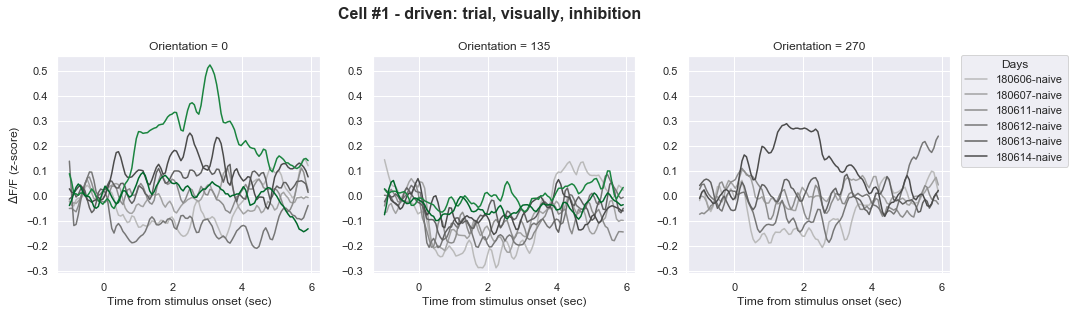

In [6]:
for cell_idx in drivers[drive_type]:
    dft = df.singlecell(mouse, trace_type, cell_idx, xmap=xmap, word=word)
    dft = dft.reset_index(level=['cell_idx', 'timestamp'])

    # filter metadata trials before merging
    trial_indexer = (
        ((dfm.orientation == 0) | (dfm.orientation == 135)
         | (dfm.orientation == 270)) &
        ((dfm.tag == 'standard') | (dfm.tag == 'learning_start')
         | (dfm.tag == 'reversal1_start') | (dfm.tag == 'reversal2_start')) &
        ((dfm.condition == 'plus') | (dfm.condition == 'minus')
         | (dfm.condition == 'neutral')) &
        (dfm.hunger == 'hungry'))
    dfm = dfm.loc[trial_indexer, :]

    # merge on filtered trials
    dff = pd.merge(dft, dfm, on=['mouse', 'date', 'run', 'trial_idx'],
                   how='inner')

    # smooth signal with rolling 3 unit window
    if smooth:
        dff['trace'] = dff['trace'].rolling(3).mean()

    # get timestamp info for plotting lines
    times = np.unique(dff['timestamp'])
    zero_sec = np.where(times <= 0)[0][-1]
    three_sec = np.where(times <= 3)[0][-1]
    
    # oris
    oris = np.array([0, 135, 270])
        
    # get pivot table for slicing
    toplot = dff.pivot_table(
        index=['date', 'run', 'trial_idx', 'orientation', 'learning_state'],
        columns='timestamp', values='trace')
    
    # create mean response per day per orientation for each cell
    mean_list = []
    for d in np.unique(toplot.reset_index()['date']):
        for o in oris:
            indexer = np.where((toplot.reset_index()['orientation'] == o) &
                       (toplot.reset_index()['date'] == d))[0]
#             test = toplot.iloc[indexer, :].mean(level=['date', 'orientation','learning_state'])
#             mean_list[str(o)].append(toplot.iloc[indexer, :].mean(level))
        
            mean_list.append(toplot.iloc[indexer, :].mean(level=['date', 'orientation', 'learning_state']))
        
    
    mean_df = pd.concat(mean_list, axis=0)
    
    # subplot params
    rows = 1
    cols = 3

    # get plot with most lines for figure legend
    count = []
    for col in range(cols):
        count.append(np.nansum(mean_df.reset_index()['orientation'] == oris[col]))
    legend_ind = np.argmax(count)
    color_ind = np.array([np.where(np.unique(mean_df.reset_index()['date']) == i)[0][0] for i in mean_df.reset_index()['date']])
    # colormap 
    day_num = len(np.unique(mean_df.reset_index()['date']))
    a = sns.color_palette("Greys", int(np.ceil(day_num*1.5)))[-day_num:]
    b = sns.color_palette("Greens", day_num)
    c = sns.color_palette("Reds", day_num)
    d = sns.color_palette("Purples", day_num)
    colors = {'naive': a, 'learning': b, 'reversal1': c, 'reversal2': d}

    # preallocate for legend
    labels = []

    # get driven tag for title
    ttag = 'trial, ' if np.isin(cell_idx, all_driven_trial) else ''
    vtag = 'visually, ' if np.isin(cell_idx, all_driven_vis) else ''
    itag = 'inhibition' if np.isin(cell_idx, all_driven_inhib) else ''
    title_tage = ttag + vtag + itag

    fig, axes = plt.subplots(rows, cols, figsize=(16, 4))
    fig.suptitle('Cell #' + str(cell_idx) + ' - driven: ' + title_tage, fontsize=16, y=1.05, weight='bold')
    for col in range(cols):
        indexer = np.where(mean_df.reset_index()['orientation'] == oris[col])[0]
        traces = mean_df.iloc[indexer,:].values
        dates = mean_df.reset_index()['date'].iloc[indexer]
        state = mean_df.reset_index()['learning_state'].iloc[indexer]
        c_ind = color_ind[indexer]
        axes[col].set_title('Orientation = ' + str(oris[col]))
        if col == 0:
            axes[col].set_ylabel(r'$\Delta$' + 'F/F (z-score)')
        axes[col].set_xlabel('Time from stimulus onset (sec)')
        for l in range(np.shape(traces)[0]):
            axes[col].plot(times, traces[l,:], color=colors[state.iloc[l]][c_ind[l]], label=(str(dates.iloc[l]) + '-' + state.iloc[l]))
            if col == legend_ind:
                labels.append(str(dates.iloc[l]) + '-' + state.iloc[l])
        if col == legend_ind:
            axes
    lgd = axes[-1].legend(axes[-1].lines, labels, loc='upper left', bbox_to_anchor=(1.02, 1.03), title='Days')

    # match y-limits
    ys = []
    for col in range(cols):
        ys.extend(axes[col].get_ylim())
    maxy = np.max(ys)
    miny = np.min(ys)
    for col in range(cols):
        axes[col].set_ylim((miny, maxy))
    
    # save 
    save_dir = paths.df_plots(mouse, pars={'trace_type': trace_type}, word=word, plot_type='traces')
    save_dir = os.path.join(save_dir, 'driven ' + str('trial'))
    if not os.path.isdir(save_dir): os.mkdir(save_dir)
    path = os.path.join(save_dir, str(mouse) + '_cell_' + str(cell_idx) + '_' + trace_type + '_' + drive_type + '.pdf')
    plt.savefig(path, bbox_inches='tight')
    print('Cell: ' + str(cell_idx) + ': done.')
#     plt.close()
    break
    

In [9]:
mean_df
count

[8, 8, 6]

In [27]:
sns.set()

In [162]:
mean_df

timestamp                          -1.000000  -0.935442  -0.870884  -0.806327  \
date   orientation learning_state                                               
170116 0           naive            0.248849   0.233258   0.185421   0.131173   
       135         naive            0.397062   0.282469   0.171140   0.173003   
       270         naive            0.146883   0.089104   0.029664   0.051917   
170118 0           naive            0.367361   0.226976   0.058269   0.034301   
       135         naive            0.059646   0.047730   0.022160   0.004994   
       270         naive            0.050918   0.037290   0.026611   0.020503   
170119 0           naive            0.152734   0.118924   0.056255   0.031092   
       135         naive            0.042135   0.042794   0.016967   0.003409   
       270         naive            0.075085   0.082176   0.065104  -0.000707   
170125 0           naive            0.018225   0.012827   0.004543  -0.011657   
       135         naive           -0.050152  -0.034998  -0.018168  -0.006961   
       270         naive           -0.038991  -0.087380  -0.117420  -0.110451   
                   learning        -0.004111   0.005560   0.071124   0.049288   
170127 270         learning        -0.159217  -0.128773  -0.079072  -0.048201   
170201 270         learning         0.007152   0.000311  -0.009967  -0.019639   
170326 0           reversal1       -0.050718  -0.032438  -0.000025   0.004038   
       135         reversal1        0.025939   0.043031   0.049134   0.045467   
       270         reversal1       -0.016950  -0.029820  -0.040274  -0.022556   
170404 0           reversal1        0.017004   0.016247   0.010733  -0.015799   
       135         reversal1        0.055509   0.033674   0.014576   0.006012   
       270         reversal1       -0.009192  -0.024004  -0.015207   0.005340   

timestamp                          -0.741769  -0.677211  -0.612653  -0.548096  \
date   orientation learning_state                                               
170116 0           naive            0.100313   0.096169   0.091684   0.073595   
       135         naive            0.158225   0.142691   0.121890   0.089065   
       270         naive            0.038608   0.003329  -0.038310  -0.058262   
170118 0           naive            0.014234  -0.008457  -0.015846  -0.021532   
       135         naive            0.025367   0.033265   0.016512  -0.013051   
       270         naive            0.021879   0.028119   0.036336   0.023179   
170119 0           naive            0.018041   0.029613   0.027044   0.017219   
       135         naive           -0.011647  -0.004793   0.012913   0.033470   
       270         naive           -0.029967  -0.056814  -0.083016  -0.086157   
170125 0           naive           -0.013056  -0.008648   0.007487   0.014231   
       135         naive            0.002446  -0.002644   0.008029   0.041833   
       270         naive           -0.092703  -0.079458  -0.082679  -0.048752   
                   learning         0.054838   0.073424   0.069905   0.024974   
170127 270         learning        -0.035573  -0.010023  -0.008816   0.060706   
170201 270         learning        -0.027734  -0.011661   0.013724   0.038256   
170326 0           reversal1        0.010638   0.027941   0.039701   0.020786   
       135         reversal1        0.020051  -0.019574  -0.033366  -0.030513   
       270         reversal1       -0.001032   0.013633  -0.003298  -0.019776   
170404 0           reversal1       -0.014642  -0.000779   0.016268   0.016070   
       135         reversal1       -0.007450  -0.009170  -0.000972   0.009974   
       270         reversal1        0.008713  -0.010761  -0.027150  -0.029422   

timestamp                          -0.483538  -0.418980  ...   5.326662  \
date   orientation learning_state                        ...              
170116 0           naive            0.036810  -0.005917  ...   0.557294   
       135         naive            0.037517  -

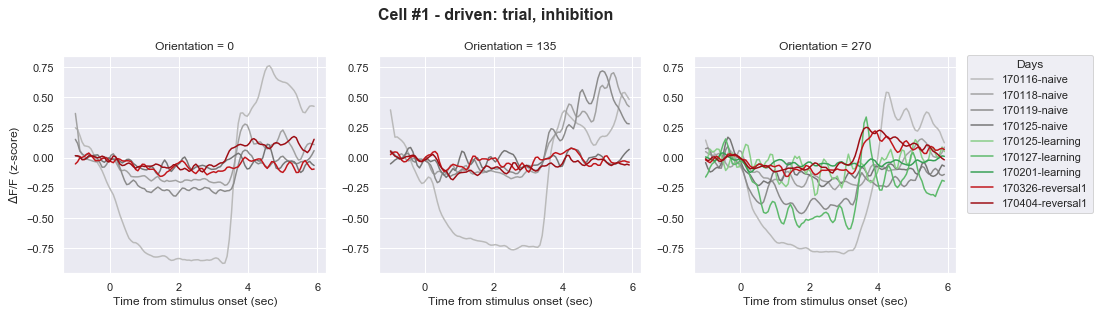

In [33]:
# subplot params
rows = 1
cols = 3

# get plot with most lines for figure legend
count = []
for col in range(cols):
    count.append(np.nansum(mean_df.reset_index()['orientation'] == oris[col]))
legend_ind = np.argmax(count)
color_ind = np.array([np.where(np.unique(mean_df.reset_index()['date']) == i)[0][0] for i in mean_df.reset_index()['date']])
# colormap 
day_num = len(np.unique(mean_df.reset_index()['date']))
a = sns.color_palette("Greys", int(np.floor(day_num*1.5)))[-day_num:-1]
b = sns.color_palette("Greens", day_num)
c = sns.color_palette("Reds", day_num)
d = sns.color_palette("Purples", day_num)
colors = {'naive': a, 'learning': b, 'reversal1': c, 'reversal2': d}

# preallocate for legend
labels = []

# get driven tag for title
ttag = 'trial, ' if np.isin(cell_idx, all_driven_trial) else ''
vtag = 'visually, ' if np.isin(cell_idx, all_driven_vis) else ''
itag = 'inhibition' if np.isin(cell_idx, all_driven_inhib) else ''
title_tage = ttag + vtag + itag

fig, axes = plt.subplots(rows, cols, figsize=(16, 4))
fig.suptitle('Cell #' + str(cell_idx) + ' - driven: ' + title_tage, fontsize=16, y=1.05, weight='bold')
for col in range(cols):
    indexer = np.where(mean_df.reset_index()['orientation'] == oris[col])[0]
    traces = mean_df.iloc[indexer,:].values
    dates = mean_df.reset_index()['date'].iloc[indexer]
    state = mean_df.reset_index()['learning_state'].iloc[indexer]
    c_ind = color_ind[indexer]
    axes[col].set_title('Orientation = ' + str(oris[col]))
    if col == 0:
        axes[col].set_ylabel(r'$\Delta$' + 'F/F (z-score)')
    axes[col].set_xlabel('Time from stimulus onset (sec)')
    for l in range(np.shape(traces)[0]):
        ln = axes[col].plot(times, traces[l,:], color=colors[state.iloc[l]][c_ind[l]], label=(str(dates.iloc[l]) + '-' + state.iloc[l]))
        if col == legend_ind:
            labels.append(str(dates.iloc[l]) + '-' + state.iloc[l])
    if col == legend_ind:
        axes
lgd = axes[-1].legend(axes[-1].lines, labels, loc='upper left', bbox_to_anchor=(1.02, 1.03), title='Days')

# match y-limits
ys = []
for col in range(cols):
    ys.extend(axes[col].get_ylim())
maxy = np.max(ys)
miny = np.min(ys)
for col in range(cols):
    axes[col].set_ylim((miny, maxy))

drive_type = 'trial'
save_dir = paths.df_plots(mouse, pars={'trace_type': trace_type}, word=word, plot_type='traces')
save_dir = os.path.join(save_dir, 'driven ' + str('trial'))
if not os.path.isdir(save_dir): os.mkdir(save_dir)
path = os.path.join(save_dir, str(mouse) + '_cell_' + str(cell_idx) + '_' + trace_type + '_' + drive_type + '.pdf')
print('Cell: ' + str(cell_idx) + ': done.')
plt.savefig(path, bbox_inches='tight')
plt.close()


AttributeError: 'AxesSubplot' object has no attribute 'label'

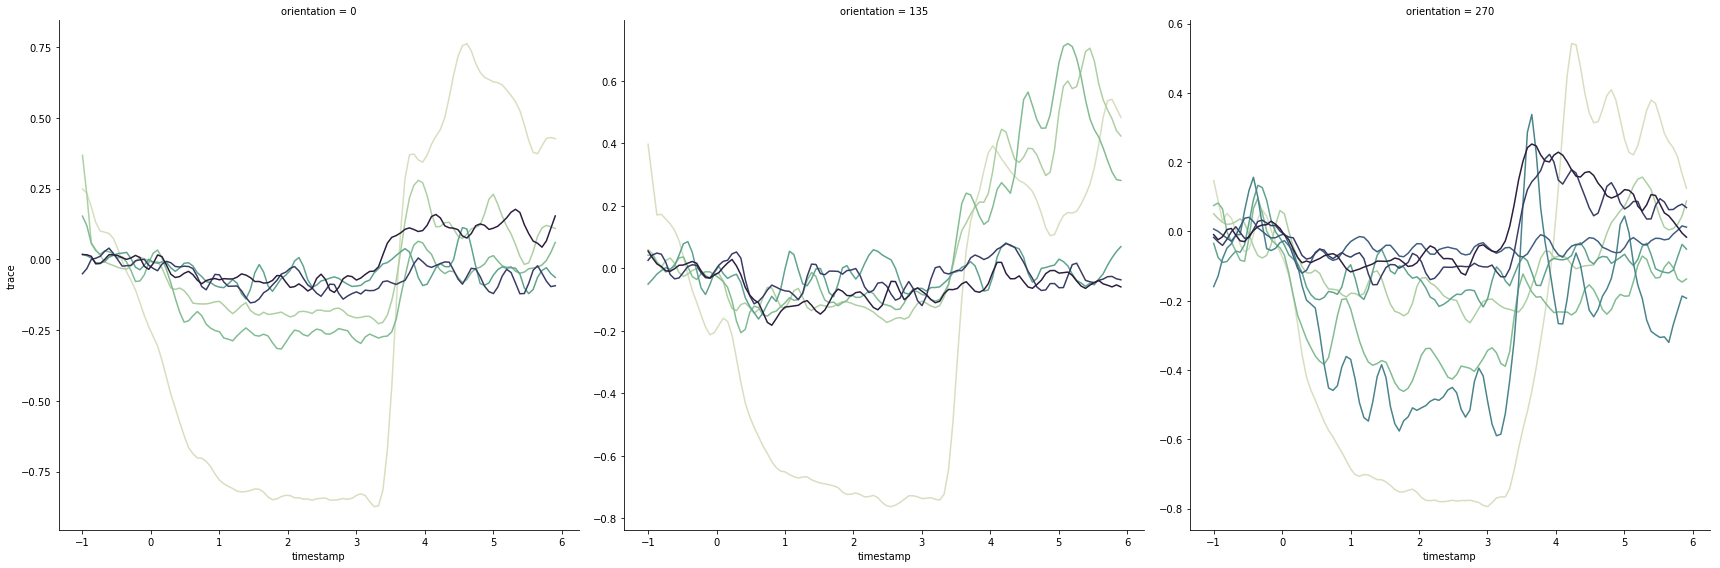

In [134]:
g = sns.FacetGrid(
    dff.reset_index(), col='orientation', hue='date',
    height=8, aspect=1, sharey=False, dropna=True, palette=cmap, legend_out=True)
cmap = sns.cubehelix_palette(len(np.unique(dff.reset_index()['date'])), start=.5, rot=-.75)
g.map(sns.lineplot, 'timestamp', 'trace', err_style=None)
# test = dff.reset_index().set_index(['date', 'orientation', 'learning_state', 'timestamp']).mean(level=['date', 'orientation', 'learning_state', 'timestamp'])

In [108]:
test.head()

run  trial_idx  cell_idx  \
date   orientation learning_state timestamp                             
170116 0           naive          -1.000000  3.0  76.804348       1.0   
                                  -0.935442  3.0  76.804348       1.0   
                                  -0.870884  3.0  76.804348       1.0   
                                  -0.806327  3.0  76.804348       1.0   
                                  -0.741769  3.0  76.804348       1.0   

                                                trace  trialerror  firstlick  \
date   orientation learning_state timestamp                                    
170116 0           naive          -1.000000  0.248849         1.0        NaN   
                                  -0.935442  0.233258         1.0        NaN   
                                  -0.870884  0.185421         1.0        NaN   
                                  -0.806327  0.131173         1.0        NaN   
                                  -0.741769  0.100313         1.0        NaN   

                                             ensure  quinine  speed  
date   orientation learning_state timestamp                          
170116 0           naive          -1.000000     NaN      NaN    NaN  
                                  -0.935442     NaN      NaN    NaN  
                                  -0.870884     NaN      NaN    NaN  
                                  -0.806327     NaN      NaN    NaN  
                                  -0.741769     NaN      NaN    NaN

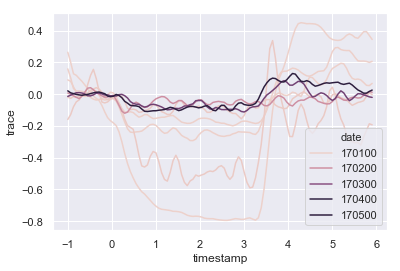

In [140]:
sns.set()
sns.set_context("notebook")
sns.lineplot(x='timestamp', y='trace', data=test.reset_index(), hue='date', err_style=None)

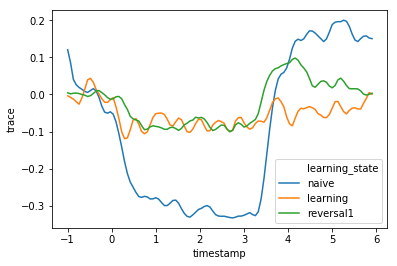

In [61]:
sns.lineplot(x='timestamp', y='trace', data=dff.reset_index('date'), hue='learning_state', err_style=None)

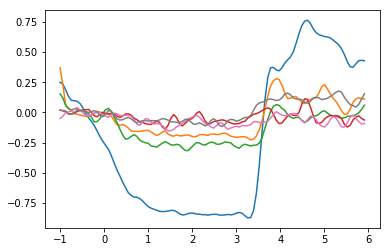

In [82]:
plt.plot(pd.concat(mean_list['0'], axis=1))

In [27]:
dff.reset_index().groupby(['mouse', 'date', 'orientation']).head()

,mouse,date,run,trial_idx,cell_idx,timestamp,trace,orientation,condition,trialerror,hunger,learning_state,tag,firstlick,ensure,quinine,speed
0,OA27,170116,3,0.0,1.0,-1.000000,NaN,0,plus,1,hungry,naive,standard,NaN,NaN,NaN,NaN
1,OA27,170116,3,0.0,1.0,-0.935442,NaN,0,plus,1,hungry,naive,standard,NaN,NaN,NaN,NaN
2,OA27,170116,3,0.0,1.0,-0.870884,-0.022615,0,plus,1,hungry,naive,standard,NaN,NaN,NaN,NaN
3,OA27,170116,3,0.0,1.0,-0.806327,0.041145,0,plus,1,hungry,naive,standard,NaN,NaN,NaN,NaN
4,OA27,170116,3,0.0,1.0,-0.741769,0.052752,0,plus,1,hungry,naive,standard,NaN,NaN,NaN,NaN
108,OA27,170116,3,1.0,1.0,-1.000000,-1.288645,135,neutral,2,hungry,naive,standard,NaN,NaN,NaN,NaN
109,OA27,170116,3,1.0,1.0,-0.935442,-0.715852,135,neutral,2,hungry,naive,standard,NaN,NaN,NaN,NaN
110,OA27,170116,3,1.0,1.0,-0.870884,-0.131758,135,neutral,2,hungry,naive,standard,NaN,NaN,NaN,NaN
111,OA27,170116,3,1.0,1.0,-0.806327,-0.115172,135,neutral,2,hungry,naive,standard,NaN,NaN,NaN,NaN
112,OA27,170116,3,1.0,1.0,-0.741769,-0.064755,135,neutral,2,hungry,naive,standard,NaN,NaN,NaN,NaN
